# Project Setup and Dependencies


In [1]:
!pip install requests pandas numpy matplotlib seaborn scikit-learn tensorflow plotly kaleido folium statsmodels --quiet

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import folium
import json
from datetime import datetime, timedelta
import time

print("Libraries installed and imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00
Libraries installed and imported.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

In [3]:
LATITUDE = 24.4898
LONGITUDE = 86.699
LOCATION_NAME = "Deoghar, IN"
HOURLY_VARIABLES = ["temperature_2m", "precipitation", "relativehumidity_2m"]

PAST_DAYS = 750


N_STEPS_LSTM = 5
N_FEATURES_LSTM = 1

ANOMALY_CONTAMINATION = 0.02

# Data Acquisition (Live API Call)

In [4]:
def fetch_climate_data(latitude, longitude, past_days, hourly_vars):
    print(f"Fetching data for coordinates: ({latitude}, {longitude})")
    ##BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
    BASE_URL = "https://historical-forecast-api.open-meteo.com/v1/forecast"

    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=past_days)).strftime('%Y-%m-%d')

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(hourly_vars),
        "timezone": "auto"
    }

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        print("Data fetched successfully!")
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON response.")
        print("Response text:", response.text)
        return None


raw_data = fetch_climate_data(LATITUDE, LONGITUDE, PAST_DAYS, HOURLY_VARIABLES)


if raw_data:
    hourly_data = raw_data.get('hourly', {})
    df = pd.DataFrame(hourly_data)

    if 'time' not in df.columns or df.empty:
         print("Error: 'time' column not found in hourly data or data is empty.")
         print("Raw Data Structure:", raw_data)
         df = pd.DataFrame()
    else:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        print(f"\nDataframe created with shape: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nLast 5 rows:")
        print(df.tail())
        print("\nData Info:")
        df.info()
else:
    print("Could not proceed without data.")
    df = pd.DataFrame()

Fetching data for coordinates: (24.4898, 86.699)
Data fetched successfully!

Dataframe created with shape: (18024, 3)

First 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2023-03-17 00:00:00            21.1            0.0                   84
2023-03-17 01:00:00            21.0            0.0                   85
2023-03-17 02:00:00            20.4            0.0                   89
2023-03-17 03:00:00            20.7            0.0                   88
2023-03-17 04:00:00            20.5            0.0                   90

Last 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2025-04-05 19:00:00            28.8            0.0                   30
2025-04-05 20:00:00            27.7            0.0                   34
2025-04-05 21:00:00            26.9            0.0           

# Data Preprocessing and Cleaning

In [5]:
if not df.empty:

    print("\nMissing values per column:")
    print(df.isnull().sum())


    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("\nMissing values after forward/backward fill:")
    print(df.isnull().sum())


    for col in HOURLY_VARIABLES:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(inplace=True)

    print(f"\nDataframe shape after cleaning: {df.shape}")
    print("\nBasic Statistics:")
    print(df.describe())
else:
    print("Skipping preprocessing as DataFrame is empty.")


Missing values per column:
temperature_2m         0
precipitation          0
relativehumidity_2m    0
dtype: int64

Missing values after forward/backward fill:
temperature_2m         0
precipitation          0
relativehumidity_2m    0
dtype: int64

Dataframe shape after cleaning: (18024, 3)

Basic Statistics:
       temperature_2m  precipitation  relativehumidity_2m
count    18024.000000   18024.000000          18024.00000
mean        25.394801       0.168941             70.32257
std          6.257963       0.772615             20.88267
min          7.300000       0.000000              9.00000
25%         21.400000       0.000000             57.00000
50%         26.300000       0.000000             76.00000
75%         29.300000       0.000000             87.00000
max         43.100000      36.200000            100.00000


# Exploratory Data Analysis (EDA) & Visualization

In [6]:
if not df.empty:
    print("\n--- Generating Visualizations ---")


    print("\nPlotting Time Series...")
    fig_ts = go.Figure()

    for col in HOURLY_VARIABLES:
        fig_ts.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col))

    fig_ts.update_layout(
        title=f'Hourly Climate Variables for {LOCATION_NAME} (Last {PAST_DAYS} Days)',
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='Variable',
        hovermode="x unified"
    )
    fig_ts.show()


    print("\nPlotting Distributions...")
    for col in HOURLY_VARIABLES:
      fig_hist = px.histogram(df, x=col, title=f'Distribution of {col}')
      fig_hist.show()


    print("\nGenerating Location Map...")
    m = folium.Map(location=[LATITUDE, LONGITUDE], zoom_start=10)
    folium.Marker(
        [LATITUDE, LONGITUDE],
        popup=f"{LOCATION_NAME}\nLat: {LATITUDE}\nLon: {LONGITUDE}",
        tooltip=LOCATION_NAME
    ).add_to(m)
    display(m)

else:
    print("Skipping Visualization as DataFrame is empty.")


--- Generating Visualizations ---

Plotting Time Series...



Plotting Distributions...



Generating Location Map...


# Climate Prediction Model (Short-Term Temperature Forecast - LSTM)


--- Building Short-Term Temperature Forecast Model (LSTM) ---
Training data shape: X=(14415, 5, 1), y=(14415, 1)
Testing data shape: X=(3604, 5, 1), y=(3604, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Training LSTM model...
Training complete.


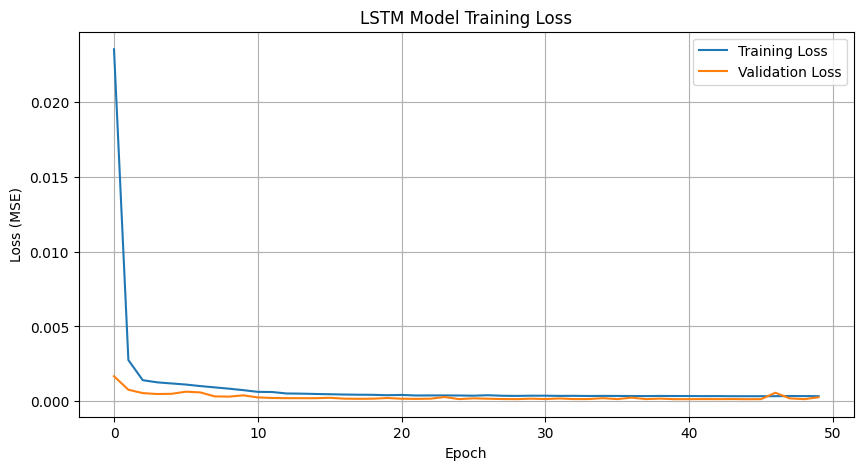

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Plotting Forecast vs Actual...



Mean Absolute Error (MAE) on Test Set: 0.69 °C
R-squared (R2) Score on Test Set: 0.98

Note: This is a simple short-term forecast based only on recent temperature history.


In [7]:
if not df.empty and 'temperature_2m' in df.columns and len(df) > N_STEPS_LSTM * 2:
    print("\n--- Building Short-Term Temperature Forecast Model (LSTM) ---")


    temp_data = df['temperature_2m'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(temp_data)


    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data)):
            end_ix = i + n_steps
            if end_ix > len(data)-1:
                break
            seq_x, seq_y = data[i:end_ix], data[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, N_STEPS_LSTM)


    X = X.reshape((X.shape[0], X.shape[1], N_FEATURES_LSTM))


    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    time_index_test = df.index[N_STEPS_LSTM:][split_idx:]

    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")


    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(N_STEPS_LSTM, N_FEATURES_LSTM)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')

    print("\nTraining LSTM model...")

    history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    print("Training complete.")


    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()



    y_pred_scaled = model_lstm.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)


    print("\nPlotting Forecast vs Actual...")
    fig_pred = go.Figure()
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_test_actual.flatten(), mode='lines', name='Actual Temperature'))
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_pred.flatten(), mode='lines', name='Predicted Temperature (LSTM)'))

    fig_pred.update_layout(
        title=f'Temperature Forecast vs Actual for {LOCATION_NAME} (Test Set)',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_pred.show()


    mae = np.mean(np.abs(y_pred - y_test_actual))
    print(f"\nMean Absolute Error (MAE) on Test Set: {mae:.2f} °C")

    r2 = r2_score(y_test_actual, y_pred)
    print(f"R-squared (R2) Score on Test Set: {r2:.2f}")

    print("\nNote: This is a simple short-term forecast based only on recent temperature history.")


else:
     print("Skipping Prediction: DataFrame is empty, 'temperature_2m' column is missing, or not enough data points.")

# Anomaly Detection (using Isolation Forest)

In [8]:
if not df.empty and 'temperature_2m' in df.columns:
    print("\n--- Performing Anomaly Detection on Temperature Data ---")


    model_iforest = IsolationForest(n_estimators=100, contamination=ANOMALY_CONTAMINATION, random_state=42)

    temp_data_if = df[['temperature_2m']].copy()
    model_iforest.fit(temp_data_if)

    df['anomaly_temp'] = model_iforest.predict(temp_data_if)


    anomalies = df[df['anomaly_temp'] == -1]
    print(f"\nDetected {len(anomalies)} potential anomalies in temperature data.")


    print("\nPlotting Temperature with Detected Anomalies...")
    fig_anomaly = go.Figure()


    fig_anomaly.add_trace(go.Scatter(
        x=df.index,
        y=df['temperature_2m'],
        mode='lines',
        name='Temperature (°C)'
    ))


    fig_anomaly.add_trace(go.Scatter(
        x=anomalies.index,
        y=anomalies['temperature_2m'],
        mode='markers',
        marker=dict(color='red', size=8, symbol='x'),
        name='Detected Anomaly'
    ))

    fig_anomaly.update_layout(
        title=f'Temperature Time Series with Anomaly Detection for {LOCATION_NAME}',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_anomaly.show()

    if not anomalies.empty:
      print("\nDetails of detected anomalies:")
      print(anomalies[['temperature_2m', 'anomaly_temp']])

else:
    print("Skipping Anomaly Detection: DataFrame is empty or 'temperature_2m' column is missing.")


--- Performing Anomaly Detection on Temperature Data ---

Detected 358 potential anomalies in temperature data.

Plotting Temperature with Detected Anomalies...



Details of detected anomalies:
                     temperature_2m  anomaly_temp
time                                             
2023-04-14 12:00:00            40.4            -1
2023-04-14 13:00:00            40.7            -1
2023-04-14 14:00:00            40.6            -1
2023-04-14 15:00:00            40.1            -1
2023-04-15 13:00:00            40.4            -1
...                             ...           ...
2025-01-10 07:00:00            10.3            -1
2025-01-11 05:00:00            10.4            -1
2025-01-11 06:00:00            10.2            -1
2025-01-11 07:00:00            10.5            -1
2025-01-27 06:00:00            10.5            -1

[358 rows x 2 columns]


# Simple Dashboard / Summary Visualization

In [9]:


if not df.empty:
    print("\n--- Summary Dashboard Components ---")


    print("\n1. Time Series Overview:")
    if 'fig_ts' in locals():
      fig_ts.show()
    else:
      print("Time series plot not available.")


    print("\n2. Temperature Forecast (Test Set):")
    if 'fig_pred' in locals():
        fig_pred.show()
    else:
      print("Forecast plot not available.")

    print("\n3. Temperature Anomaly Detection:")
    if 'fig_anomaly' in locals():
        fig_anomaly.show()
    else:
      print("Anomaly plot not available.")


    print("\n4. Location Context:")
    if 'm' in locals():
      display(m)
    else:
      print("Map not available.")

else:
    print("Cannot generate summary dashboard components as DataFrame is empty.")


--- Summary Dashboard Components ---

1. Time Series Overview:



2. Temperature Forecast (Test Set):



3. Temperature Anomaly Detection:



4. Location Context:


# Predicting 24 Hrs

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.preprocessing import MinMaxScaler


def predict_next_24_hours(model, scaler, last_data_points):
    predictions = []
    current_sequence = last_data_points.copy()
    for _ in range(24):
        X = np.array([current_sequence]).reshape(1, N_STEPS_LSTM, N_FEATURES_LSTM)
        next_value_scaled = model.predict(X)
        next_value = scaler.inverse_transform(next_value_scaled)[0, 0]
        predictions.append(next_value)
        current_sequence = np.append(current_sequence[1:], next_value_scaled)
    return np.array(predictions)


if not isinstance(df, pd.DataFrame) or df.empty or 'temperature_2m' not in df.columns or len(df) <= N_STEPS_LSTM * 2:
    print("Error: DataFrame 'df' is not properly defined or does not contain enough data and 'temperature_2m' column.")
else:
    last_data_points_scaled = scaler.transform(df['temperature_2m'][-N_STEPS_LSTM:].values.reshape(-1, 1))
    last_data_points = last_data_points_scaled.flatten()

    predicted_temps = predict_next_24_hours(model_lstm, scaler, last_data_points)

    now = datetime.now()
    prediction_times = [now + timedelta(hours=i) for i in range(1, 25)]

    prediction_df = pd.DataFrame({'time': prediction_times, 'predicted_temperature': predicted_temps})
    prediction_df = prediction_df.set_index('time')

    three_days_ago = now - timedelta(days=3)
    plot_start = max(three_days_ago, df.index.min())
    plot_end = now + timedelta(hours=24)


    fig = go.Figure()


    filtered_df = df[(df.index >= plot_start) & (df.index <= now)]
    fig.add_trace(go.Scatter(
        x=filtered_df.index,
        y=filtered_df['temperature_2m'],
        mode='lines',
        name='Historical Temperature',
        line=dict(color='blue')
    ))


    fig.add_trace(go.Scatter(
        x=prediction_df.index,
        y=prediction_df['predicted_temperature'],
        mode='lines',
        name='Predicted Temperature',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title='Temperature Predictions (Next 24 Hours)',
        xaxis_title='Time (Hour)',
        yaxis_title='Temperature',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis_gridcolor='lightgray',
        yaxis_gridcolor='lightgray',
        plot_bgcolor='white'
    )

    iplot(fig)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


# Extra

#Flask

In [11]:
!pip install pyngrok

# Data Conversion

In [12]:
import numpy as np
mae_value = float(mae) if 'mae' in locals() and mae is not None and np.isfinite(mae) else None
r2_value = float(r2) if 'r2' in locals() and r2 is not None and np.isfinite(r2) else None
data_points_value = int(len(df)) if 'df' in locals() and not df.empty else 0
anomaly_count = int(len(anomalies)) if 'anomalies' in locals() and not anomalies.empty else 0
time_series_plot_json = fig_ts.to_json() if 'fig_ts' in locals() else None
forecast_vs_actual_plot_json = fig_pred.to_json() if 'fig_pred' in locals() else None
anomaly_plot_json = fig_anomaly.to_json() if 'fig_anomaly' in locals() else None
future_forecast_plot_json = fig.to_json() if 'fig' in locals() else None
map_html_str = m._repr_html_() if 'm' in locals() else None
anomaly_details_list = []
anomaly_count = 0
if 'anomalies' in locals() and not anomalies.empty:
    anomaly_count = len(anomalies)
    anomalies_copy = anomalies.copy()
    anomalies_copy['time_str'] = anomalies_copy.index.strftime('%Y-%m-%d %H:%M:%S')
    anomaly_details_list = anomalies_copy[['time_str', 'temperature_2m']].rename(columns={'time_str': 'time'}).to_dict('records')

latitude_val = LATITUDE
longitude_val = LONGITUDE
location_name_val = LOCATION_NAME
past_days_val = PAST_DAYS
lstm_steps_val = N_STEPS_LSTM
anomaly_contamination_val = ANOMALY_CONTAMINATION

print("Outputs captured and converted for Flask.")

Outputs captured and converted for Flask.


# Checking 2

In [13]:
print("--- Checking Captured Variables for Flask ---")

vars_to_check = [
    'location_name_val', 'latitude_val', 'longitude_val', 'past_days_val',
    'data_points_value', 'lstm_steps_val', 'anomaly_contamination_val',
    'time_series_plot_json', 'anomaly_plot_json', 'forecast_vs_actual_plot_json',
    'future_forecast_plot_json', 'mae_value', 'r2_value', 'anomaly_count',
    'map_html_str', 'anomaly_details_list'
]

all_vars_ok = True
for var_name in vars_to_check:
    if var_name not in globals():
        print(f"ERROR: Variable '{var_name}' not found!")
        all_vars_ok = False
    else:
        value = globals()[var_name]
        print(f"Variable '{var_name}': Type = {type(value)}")
        if var_name.endswith('_json') and not isinstance(value, (str, type(None))):
            print(f"  WARNING: Expected JSON string or None for '{var_name}', got {type(value)}")
            all_vars_ok = False
        elif var_name == 'map_html_str' and not isinstance(value, (str, type(None))):
             print(f"  WARNING: Expected HTML string or None for '{var_name}', got {type(value)}")
             all_vars_ok = False
        elif var_name in ['mae_value', 'r2_value'] and not isinstance(value, (float, int, type(None))):
             import numpy as np
             if isinstance(value, (np.float_, np.float16, np.float32, np.float64)) and np.isnan(value):
                  print(f"  INFO: Variable '{var_name}' is NaN.")
             elif not isinstance(value, (float, int, type(None))):
                print(f"  WARNING: Expected float/int or None for '{var_name}', got {type(value)}")
                all_vars_ok = False
        elif var_name == 'anomaly_details_list' and isinstance(value, list) and value:
             item = value[0]
             if not isinstance(item, dict):
                  print(f"  WARNING: Expected 'anomaly_details_list' to be list of dicts, first item is {type(item)}")
                  all_vars_ok = False
             else:
                  for k, v in item.items():
                       if not isinstance(v, (str, int, float, bool, type(None))):
                            print(f"  WARNING: Inside anomaly_details_list dict, key '{k}' has non-JSON type {type(v)}")
                            all_vars_ok = False

if not all_vars_ok:
    print("\n!!! Potential issues found with captured variables. Check warnings/errors above. !!!")
else:
    print("\n--- Variable check complete. All expected variables found with seemingly JSON-compatible types. ---")

--- Checking Captured Variables for Flask ---
Variable 'location_name_val': Type = <class 'str'>
Variable 'latitude_val': Type = <class 'float'>
Variable 'longitude_val': Type = <class 'float'>
Variable 'past_days_val': Type = <class 'int'>
Variable 'data_points_value': Type = <class 'int'>
Variable 'lstm_steps_val': Type = <class 'int'>
Variable 'anomaly_contamination_val': Type = <class 'float'>
Variable 'time_series_plot_json': Type = <class 'str'>
Variable 'anomaly_plot_json': Type = <class 'str'>
Variable 'forecast_vs_actual_plot_json': Type = <class 'str'>
Variable 'future_forecast_plot_json': Type = <class 'str'>
Variable 'mae_value': Type = <class 'float'>
Variable 'r2_value': Type = <class 'float'>
Variable 'anomaly_count': Type = <class 'int'>
Variable 'map_html_str': Type = <class 'str'>
Variable 'anomaly_details_list': Type = <class 'list'>

--- Variable check complete. All expected variables found with seemingly JSON-compatible types. ---


In [14]:
print("\n--- FINAL CAPTURE CHECK ---")
print(f"Type of time_series_plot_json: {type(time_series_plot_json)}")
print(f"Is time_series_plot_json None?: {time_series_plot_json is None}")
if time_series_plot_json is not None:
    print(f"time_series_plot_json (first 100 chars): {time_series_plot_json[:100]}")

print(f"\nType of mae_value: {type(mae_value)}")
print(f"Value of mae_value: {mae_value}")

print(f"\nType of map_html_str: {type(map_html_str)}")
print(f"Is map_html_str None?: {map_html_str is None}")
if map_html_str is not None:
    print(f"map_html_str (first 100 chars): {map_html_str[:100]}")

print(f"\nType of anomaly_details_list: {type(anomaly_details_list)}")
if isinstance(anomaly_details_list, list) and anomaly_details_list:
     print(f"Type of first item in anomaly_details_list: {type(anomaly_details_list[0])}")
     print(f"First item: {anomaly_details_list[0]}")


--- FINAL CAPTURE CHECK ---
Type of time_series_plot_json: <class 'str'>
Is time_series_plot_json None?: False
time_series_plot_json (first 100 chars): {"data":[{"mode":"lines","name":"temperature_2m","x":["2023-03-17T00:00:00","2023-03-17T01:00:00","2

Type of mae_value: <class 'float'>
Value of mae_value: 0.6885202759775546

Type of map_html_str: <class 'str'>
Is map_html_str None?: False
map_html_str (first 100 chars): <div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><spa

Type of anomaly_details_list: <class 'list'>
Type of first item in anomaly_details_list: <class 'dict'>
First item: {'time': '2023-04-14 12:00:00', 'temperature_2m': 40.4}


# Flask 2

In [15]:
from flask import Flask, jsonify, render_template, send_from_directory
from pyngrok import ngrok, conf
import os
import threading
import json
ngrok.kill()

DRIVE_PROJECT_FOLDER = '/content/drive/MyDrive/template'
port_no=5012
ngrok.set_auth_token('2vI1Gvja9F5aux1SnvCQzaQ6kXZ_iEHSCjw9JHBA6kGYRspg')

if not os.path.isdir(DRIVE_PROJECT_FOLDER):
    print(f"ERROR: The specified Google Drive folder does not exist: {DRIVE_PROJECT_FOLDER}")
    raise SystemExit(f"Directory not found: {DRIVE_PROJECT_FOLDER}")
else:
    if not os.path.exists(os.path.join(DRIVE_PROJECT_FOLDER, 'index.html')):
         raise SystemExit(f"index.html not found in {DRIVE_PROJECT_FOLDER}")
    if not os.path.exists(os.path.join(DRIVE_PROJECT_FOLDER, 'style.css')):
         raise SystemExit(f"style.css not found in {DRIVE_PROJECT_FOLDER}")
    print(f"Project folder and HTML/CSS files found in: {DRIVE_PROJECT_FOLDER}")

app = Flask(__name__,
            template_folder=DRIVE_PROJECT_FOLDER,
            static_folder=DRIVE_PROJECT_FOLDER)

@app.route('/')
def index():
    print(f"Serving index.html from {app.template_folder}")
    return render_template('index.html')

@app.route('/style.css')
def style():
    print(f"Serving style.css from {app.static_folder}")
    return send_from_directory(app.static_folder, 'style.css')

@app.route('/data')
def get_data():
    print("Received request for /data endpoint. Preparing captured data.")

    data_payload = {
        "location_name": location_name_val if 'location_name_val' in globals() else 'N/A',
        "latitude": latitude_val if 'latitude_val' in globals() else None,
        "longitude": longitude_val if 'longitude_val' in globals() else None,
        "past_days": past_days_val if 'past_days_val' in globals() else None,
        "data_points": data_points_value if 'data_points_value' in globals() else None,
         "lstm_steps": lstm_steps_val if 'lstm_steps_val' in globals() else None,
         "anomaly_contamination": anomaly_contamination_val if 'anomaly_contamination_val' in globals() else None,
        "plots": {

            "time_series": time_series_plot_json if 'time_series_plot_json' in globals() else None,
            "anomaly": anomaly_plot_json if 'anomaly_plot_json' in globals() else None,
            "forecast_vs_actual": forecast_vs_actual_plot_json if 'forecast_vs_actual_plot_json' in globals() else None,
             "future_forecast": future_forecast_plot_json if 'future_forecast_plot_json' in globals() else None,
        },
        "metrics": {
            "anomaly_count": anomaly_count if 'anomaly_count' in globals() else None,
            "mae": mae_value if 'mae_value' in globals() else None,
            "r2": r2_value if 'r2_value' in globals() else None,
        },

        "map_html": map_html_str if 'map_html_str' in globals() else None,
        "anomaly_details": anomaly_details_list if 'anomaly_details_list' in globals() else [],
        "error": None
    }

    print("Sending captured data as JSON response.")
    return jsonify(data_payload)


if ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN"):
    print("ERROR: Please replace 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok token.")
else:
    try:
        conf.get_default().auth_token = ngrok.set_auth_token('2vI1Gvja9F5aux1SnvCQzaQ6kXZ_iEHSCjw9JHBA6kGYRspg')
        ngrok.kill()

        def run_flask():
            print("Starting Flask server...")
            app.run(port=port_no, use_reloader=False, debug=False)

        print("Starting ngrok tunnel...")
        public_url = ngrok.connect(port_no).public_url
        print(f" * Dashboard Public URL: {public_url}")
        print(f" * Access the dashboard at: {public_url}")
        print(" * This serves the results CAPTURED from the previous cells.")
        print(" * Re-run the analysis cells and the capture code cell if you want to update the data.")


        flask_thread = threading.Thread(target=run_flask)
        flask_thread.start()
        print("Flask app serving captured data in background thread.")

    except Exception as e:
        print(f"ERROR setting up ngrok or Flask: {e}")

Project folder and HTML/CSS files found in: /content/drive/MyDrive/template
Starting ngrok tunnel...
 * Dashboard Public URL: https://f24c-34-147-51-160.ngrok-free.app
 * Access the dashboard at: https://f24c-34-147-51-160.ngrok-free.app
 * This serves the results CAPTURED from the previous cells.
 * Re-run the analysis cells and the capture code cell if you want to update the data.
Starting Flask server...
Flask app serving captured data in background thread.
